# Experiment Results Evaluation

## Comprehensive Analysis and Visualization

This notebook provides in-depth analysis of parking detection experiment results:

### Features:
- **Individual Experiment Analysis** - Detailed breakdown of single model runs
- **Model Comparison Analysis** - Side-by-side performance comparisons
- **Performance Visualizations** - Charts and graphs for insights
- **Tracking Quality Assessment** - Analysis of detection consistency
- **Export Capabilities** - Generate reports and summaries

### Data Sources:
- Individual experiment results from `../output/experiments/`
- Model comparison results from `../output/comparisons/`
- Custom JSON/CSV data files

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Evaluation tools loaded successfully!")
print("Available analysis functions:")
print("- load_experiment_results()")
print("- load_comparison_results()")
print("- analyze_single_experiment()")
print("- analyze_model_comparison()")
print("- create_performance_visualizations()")

Evaluation tools loaded successfully!
Available analysis functions:
- load_experiment_results()
- load_comparison_results()
- analyze_single_experiment()
- analyze_model_comparison()
- create_performance_visualizations()


In [4]:
class ExperimentEvaluator:
    def __init__(self):
        self.experiments_dir = "../output/experiments"
        self.comparisons_dir = "../output/comparisons"
        self.current_data = None
        self.data_type = None
        
    def list_available_experiments(self):
        """List all available experiment results"""
        print("AVAILABLE EXPERIMENT RESULTS:")
        print("=" * 50)
        
        # Individual experiments
        if os.path.exists(self.experiments_dir):
            experiments = [d for d in os.listdir(self.experiments_dir) 
                          if os.path.isdir(os.path.join(self.experiments_dir, d))]
            
            if experiments:
                print(f"\nIndividual Experiments ({len(experiments)} found):")
                for i, exp in enumerate(sorted(experiments)[-10:], 1):  # Show last 10
                    exp_path = os.path.join(self.experiments_dir, exp)
                    results_file = os.path.join(exp_path, "results.json")
                    if os.path.exists(results_file):
                        # Extract basic info
                        with open(results_file, 'r') as f:
                            data = json.load(f)
                        model = data.get('experiment_id', exp).split('_')[0]
                        print(f"  {i:2}. {exp[:50]}... (Model: {model})")
                if len(experiments) > 10:
                    print(f"     ... and {len(experiments)-10} more")
            else:
                print("\nNo individual experiments found")
        
        # Model comparisons
        if os.path.exists(self.comparisons_dir):
            comparisons = [d for d in os.listdir(self.comparisons_dir) 
                          if os.path.isdir(os.path.join(self.comparisons_dir, d))]
            
            if comparisons:
                print(f"\nModel Comparisons ({len(comparisons)} found):")
                for i, comp in enumerate(sorted(comparisons)[-5:], 1):  # Show last 5
                    comp_path = os.path.join(self.comparisons_dir, comp)
                    results_file = os.path.join(comp_path, "comparison_results.json")
                    if os.path.exists(results_file):
                        with open(results_file, 'r') as f:
                            data = json.load(f)
                        models_count = data.get('models_tested', 0)
                        video = data.get('video_name', 'unknown')
                        print(f"  {i}. {comp} ({models_count} models, {video})")
                if len(comparisons) > 5:
                    print(f"     ... and {len(comparisons)-5} more")
            else:
                print("\nNo model comparisons found")
                
    def load_experiment_results(self, experiment_path):
        """Load individual experiment results"""
        if not os.path.isabs(experiment_path):
            experiment_path = os.path.join(self.experiments_dir, experiment_path)
            
        results_file = os.path.join(experiment_path, "results.json")
        
        if not os.path.exists(results_file):
            print(f"Results file not found: {results_file}")
            return None
            
        try:
            with open(results_file, 'r') as f:
                data = json.load(f)
                
            self.current_data = data
            self.data_type = "experiment"
            
            print("EXPERIMENT LOADED SUCCESSFULLY")
            print("=" * 40)
            print(f"Experiment ID: {data['experiment_id']}")
            print(f"Model: {data.get('model_path', 'Unknown')}")
            print(f"Video: {data.get('video_path', 'Unknown')}")
            
            stats = data.get('detection_stats', {})
            print(f"Frames: {stats.get('total_frames', 0)}")
            print(f"Detections: {stats.get('total_detections', 0)}")
            print(f"Parked Vehicles: {stats.get('unique_parked', 0)}")
            
            return data
            
        except Exception as e:
            print(f"Error loading experiment: {e}")
            return None
            
    def load_comparison_results(self, comparison_path):
        """Load model comparison results"""
        if not os.path.isabs(comparison_path):
            comparison_path = os.path.join(self.comparisons_dir, comparison_path)
            
        results_file = os.path.join(comparison_path, "comparison_results.json")
        csv_file = os.path.join(comparison_path, "model_comparison.csv")
        
        if not os.path.exists(results_file):
            print(f"Results file not found: {results_file}")
            return None
            
        try:
            with open(results_file, 'r') as f:
                data = json.load(f)
                
            # Also load CSV for easier analysis
            if os.path.exists(csv_file):
                data['comparison_df'] = pd.read_csv(csv_file)
                
            self.current_data = data
            self.data_type = "comparison"
            
            print("COMPARISON LOADED SUCCESSFULLY")
            print("=" * 40)
            print(f"Comparison ID: {data['comparison_id']}")
            print(f"Video: {data['video_name']}")
            print(f"Models Tested: {data['models_tested']}")
            
            successful = len([r for r in data['results'] if r.get('success', False)])
            print(f"Successful Tests: {successful}/{data['models_tested']}")
            
            return data
            
        except Exception as e:
            print(f"Error loading comparison: {e}")
            return None
            
    def analyze_single_experiment(self):
        """Analyze a single experiment in detail"""
        if not self.current_data or self.data_type != "experiment":
            print("No experiment data loaded. Use load_experiment_results() first.")
            return
            
        data = self.current_data
        print("\nDETAILED EXPERIMENT ANALYSIS")
        print("=" * 60)
        
        # Basic info
        print(f"\nEXPERIMENT OVERVIEW:")
        print(f"Model: {os.path.basename(data.get('model_path', 'Unknown'))}")
        print(f"Video: {os.path.basename(data.get('video_path', 'Unknown'))}")
        print(f"Experiment ID: {data['experiment_id']}")
        
        # Performance metrics
        perf = data.get('performance', {})
        stats = data.get('detection_stats', {})
        
        print(f"\nPERFORMANCE METRICS:")
        print(f"Average FPS: {perf.get('avg_fps', 0):.2f}")
        print(f"Min FPS: {perf.get('min_fps', 0):.2f}")
        print(f"Max FPS: {perf.get('max_fps', 0):.2f}")
        print(f"Processing Time: {stats.get('processing_time', 0):.1f}s")
        
        # Detection metrics
        total_frames = stats.get('total_frames', 1)
        total_detections = stats.get('total_detections', 0)
        detection_rate = total_detections / total_frames if total_frames > 0 else 0
        
        print(f"\nDETECTION METRICS:")
        print(f"Total Frames: {total_frames:,}")
        print(f"Total Detections: {total_detections:,}")
        print(f"Detection Rate: {detection_rate:.3f} detections/frame")
        print(f"Parked Vehicles: {stats.get('unique_parked', 0)}")
        
        # Tracking quality
        tracking_gaps = stats.get('tracking_gaps_total', 0)
        vehicles_with_issues = stats.get('vehicles_with_tracking_issues', 0)
        tracking_quality = 100 - (tracking_gaps / max(1, total_detections) * 100)
        
        print(f"\nTRACKING QUALITY:")
        print(f"Tracking Gaps: {tracking_gaps}")
        print(f"Vehicles with Issues: {vehicles_with_issues}")
        print(f"Tracking Quality Score: {tracking_quality:.1f}%")
        
        # Parked vehicles details
        parked_vehicles = data.get('parked_vehicles', [])
        if parked_vehicles:
            print(f"\nPARKED VEHICLES DETAILS:")
            for vehicle in parked_vehicles:
                print(f"  Vehicle {vehicle['track_id']}: Area {vehicle['area_id']}, "
                      f"{vehicle['duration']:.1f}s at {vehicle['time']:.1f}s")
        
        # Tracking issues details
        tracking_issues = data.get('tracking_issues', [])
        if tracking_issues:
            print(f"\nTRACKING ISSUES SUMMARY:")
            gap_durations = [issue['gap_duration_seconds'] for issue in tracking_issues]
            print(f"  Average gap duration: {np.mean(gap_durations):.2f}s")
            print(f"  Max gap duration: {np.max(gap_durations):.2f}s")
            print(f"  Total gaps: {len(tracking_issues)}")
            
    def analyze_model_comparison(self):
        """Analyze model comparison results"""
        if not self.current_data or self.data_type != "comparison":
            print("No comparison data loaded. Use load_comparison_results() first.")
            return
            
        data = self.current_data
        print("\nMODEL COMPARISON ANALYSIS")
        print("=" * 60)
        
        # Basic info
        print(f"\nCOMPARISON OVERVIEW:")
        print(f"Video: {data['video_name']}")
        print(f"Models Tested: {data['models_tested']}")
        print(f"Timestamp: {data['timestamp']}")
        
        # Get successful results
        successful_results = [r for r in data['results'] if r.get('success', False)]
        
        if not successful_results:
            print("No successful experiments to analyze!")
            return
            
        print(f"Successful Tests: {len(successful_results)}/{data['models_tested']}")
        
        # Create DataFrame for analysis
        df = pd.DataFrame(successful_results)
        
        # Performance ranking
        df_sorted = df.sort_values('overall_score', ascending=False)
        
        print(f"\nPERFORMANCE RANKING:")
        print(f"{'Rank':<4} {'Model':<10} {'Overall':<8} {'FPS':<8} {'Detections':<11} {'Parked':<7} {'Gaps':<5}")
        print("-" * 65)
        
        for i, (_, row) in enumerate(df_sorted.iterrows(), 1):
            print(f"{i:<4} {row['model_name']:<10} {row['overall_score']:<8.1f} "
                  f"{row['avg_fps']:<8.1f} {row['total_detections']:<11} "
                  f"{row['parked_vehicles']:<7} {row['tracking_gaps']:<5}")
        
        # Statistical analysis
        print(f"\nSTATISTICAL SUMMARY:")
        print(f"FPS - Mean: {df['avg_fps'].mean():.1f}, Std: {df['avg_fps'].std():.1f}")
        print(f"Detections - Mean: {df['total_detections'].mean():.0f}, Std: {df['total_detections'].std():.0f}")
        print(f"Overall Score - Mean: {df['overall_score'].mean():.1f}, Std: {df['overall_score'].std():.1f}")
        
        # Best performers
        best_overall = df.loc[df['overall_score'].idxmax()]
        fastest = df.loc[df['avg_fps'].idxmax()]
        most_detections = df.loc[df['total_detections'].idxmax()]
        best_tracking = df.loc[df['tracking_quality_score'].idxmax()]
        
        print(f"\nBEST PERFORMERS:")
        print(f"Overall: {best_overall['model_name']} (Score: {best_overall['overall_score']:.1f})")
        print(f"Speed: {fastest['model_name']} (FPS: {fastest['avg_fps']:.1f})")
        print(f"Detections: {most_detections['model_name']} (Count: {most_detections['total_detections']})")
        print(f"Tracking: {best_tracking['model_name']} (Quality: {best_tracking['tracking_quality_score']:.1f})")
        
        return df_sorted

In [5]:
class VisualizationTools:
    def __init__(self, evaluator):
        self.evaluator = evaluator
        
    def plot_fps_timeline(self):
        """Plot FPS over time for single experiment"""
        if not self.evaluator.current_data or self.evaluator.data_type != "experiment":
            print("Load an experiment first!")
            return
            
        data = self.evaluator.current_data
        fps_data = data.get('fps_data', [])
        
        if not fps_data:
            print("No FPS data available")
            return
            
        plt.figure(figsize=(15, 6))
        
        # Plot raw FPS
        plt.subplot(1, 2, 1)
        plt.plot(fps_data, alpha=0.7, linewidth=0.5)
        plt.title('FPS Timeline (Raw)')
        plt.xlabel('Frame')
        plt.ylabel('FPS')
        plt.grid(True, alpha=0.3)
        
        # Plot smoothed FPS
        plt.subplot(1, 2, 2)
        window_size = min(30, len(fps_data) // 10)
        if window_size > 1:
            smoothed = pd.Series(fps_data).rolling(window=window_size, center=True).mean()
            plt.plot(smoothed, color='red', linewidth=2, label=f'Smoothed (window={window_size})')
        
        plt.axhline(y=np.mean(fps_data), color='green', linestyle='--', 
                   label=f'Average: {np.mean(fps_data):.1f}')
        plt.title('FPS Timeline (Smoothed)')
        plt.xlabel('Frame')
        plt.ylabel('FPS')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"\nFPS STATISTICS:")
        print(f"Mean: {np.mean(fps_data):.2f}")
        print(f"Median: {np.median(fps_data):.2f}")
        print(f"Std Dev: {np.std(fps_data):.2f}")
        print(f"Min: {np.min(fps_data):.2f}")
        print(f"Max: {np.max(fps_data):.2f}")
        
    def plot_model_comparison(self):
        """Plot model comparison visualizations"""
        if not self.evaluator.current_data or self.evaluator.data_type != "comparison":
            print("Load a comparison first!")
            return
            
        data = self.evaluator.current_data
        successful_results = [r for r in data['results'] if r.get('success', False)]
        
        if not successful_results:
            print("No successful results to plot!")
            return
            
        df = pd.DataFrame(successful_results)
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Overall Score Comparison
        ax1 = axes[0, 0]
        bars1 = ax1.bar(df['model_name'], df['overall_score'], 
                       color=plt.cm.viridis(df['overall_score']/100))
        ax1.set_title('Overall Performance Score')
        ax1.set_ylabel('Score (0-100)')
        ax1.set_xlabel('Model')
        plt.setp(ax1.get_xticklabels(), rotation=45)
        
        # Add value labels on bars
        for bar, score in zip(bars1, df['overall_score']):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{score:.1f}', ha='center', va='bottom')
        
        # 2. FPS vs Detection Trade-off
        ax2 = axes[0, 1]
        scatter = ax2.scatter(df['avg_fps'], df['total_detections'], 
                            s=df['overall_score']*5, c=df['overall_score'],
                            cmap='viridis', alpha=0.7)
        ax2.set_title('Speed vs Detection Trade-off\n(Size = Overall Score)')
        ax2.set_xlabel('Average FPS')
        ax2.set_ylabel('Total Detections')
        
        # Add model labels
        for _, row in df.iterrows():
            ax2.annotate(row['model_name'], 
                        (row['avg_fps'], row['total_detections']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.8)
        
        plt.colorbar(scatter, ax=ax2, label='Overall Score')
        
        # 3. Tracking Quality Comparison
        ax3 = axes[1, 0]
        bars3 = ax3.bar(df['model_name'], df['tracking_quality_score'],
                       color=plt.cm.RdYlGn(df['tracking_quality_score']/100))
        ax3.set_title('Tracking Quality Score')
        ax3.set_ylabel('Quality Score (0-100)')
        ax3.set_xlabel('Model')
        plt.setp(ax3.get_xticklabels(), rotation=45)
        
        # Add value labels
        for bar, score in zip(bars3, df['tracking_quality_score']):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{score:.1f}', ha='center', va='bottom')
        
        # 4. Processing Time Comparison
        ax4 = axes[1, 1]
        bars4 = ax4.bar(df['model_name'], df['processing_time'],
                       color=plt.cm.plasma_r(df['processing_time']/df['processing_time'].max()))
        ax4.set_title('Processing Time')
        ax4.set_ylabel('Time (seconds)')
        ax4.set_xlabel('Model')
        plt.setp(ax4.get_xticklabels(), rotation=45)
        
        # Add value labels
        for bar, time in zip(bars4, df['processing_time']):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{time:.1f}s', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
    def plot_tracking_analysis(self):
        """Plot tracking issues analysis"""
        if not self.evaluator.current_data:
            print("Load experiment or comparison data first!")
            return
            
        if self.evaluator.data_type == "experiment":
            self._plot_single_tracking_analysis()
        elif self.evaluator.data_type == "comparison":
            self._plot_comparison_tracking_analysis()
            
    def _plot_single_tracking_analysis(self):
        """Plot tracking analysis for single experiment"""
        data = self.evaluator.current_data
        tracking_issues = data.get('tracking_issues', [])
        
        if not tracking_issues:
            print("No tracking issues found!")
            return
            
        df_issues = pd.DataFrame(tracking_issues)
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Gap duration distribution
        ax1 = axes[0]
        ax1.hist(df_issues['gap_duration_seconds'], bins=20, alpha=0.7, edgecolor='black')
        ax1.set_title('Gap Duration Distribution')
        ax1.set_xlabel('Gap Duration (seconds)')
        ax1.set_ylabel('Frequency')
        ax1.axvline(df_issues['gap_duration_seconds'].mean(), color='red', 
                   linestyle='--', label=f'Mean: {df_issues["gap_duration_seconds"].mean():.2f}s')
        ax1.legend()
        
        # 2. Gap timeline
        ax2 = axes[1]
        ax2.scatter(df_issues['lost_frame'], df_issues['gap_duration_seconds'], alpha=0.6)
        ax2.set_title('Tracking Gaps Timeline')
        ax2.set_xlabel('Frame Number')
        ax2.set_ylabel('Gap Duration (seconds)')
        
        # 3. Gaps per vehicle
        gaps_per_vehicle = df_issues['track_id'].value_counts()
        ax3 = axes[2]
        ax3.bar(range(len(gaps_per_vehicle)), gaps_per_vehicle.values)
        ax3.set_title('Gaps per Vehicle')
        ax3.set_xlabel('Vehicle Rank')
        ax3.set_ylabel('Number of Gaps')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nTRACKING STATISTICS:")
        print(f"Total gaps: {len(tracking_issues)}")
        print(f"Unique vehicles with gaps: {df_issues['track_id'].nunique()}")
        print(f"Average gap duration: {df_issues['gap_duration_seconds'].mean():.2f}s")
        print(f"Max gap duration: {df_issues['gap_duration_seconds'].max():.2f}s")
        
    def _plot_comparison_tracking_analysis(self):
        """Plot tracking analysis for model comparison"""
        data = self.evaluator.current_data
        successful_results = [r for r in data['results'] if r.get('success', False)]
        df = pd.DataFrame(successful_results)
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # 1. Tracking gaps comparison
        ax1 = axes[0]
        bars = ax1.bar(df['model_name'], df['tracking_gaps'], 
                      color=plt.cm.Reds(df['tracking_gaps']/df['tracking_gaps'].max()))
        ax1.set_title('Tracking Gaps by Model')
        ax1.set_ylabel('Number of Gaps')
        ax1.set_xlabel('Model')
        plt.setp(ax1.get_xticklabels(), rotation=45)
        
        for bar, gaps in zip(bars, df['tracking_gaps']):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{gaps}', ha='center', va='bottom')
        
        # 2. Quality score vs gaps
        ax2 = axes[1]
        ax2.scatter(df['tracking_gaps'], df['tracking_quality_score'], 
                   s=100, alpha=0.7, c=df['overall_score'], cmap='viridis')
        ax2.set_title('Tracking Quality vs Gaps')
        ax2.set_xlabel('Number of Tracking Gaps')
        ax2.set_ylabel('Tracking Quality Score')
        
        for _, row in df.iterrows():
            ax2.annotate(row['model_name'], 
                        (row['tracking_gaps'], row['tracking_quality_score']),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8)
        
        plt.tight_layout()
        plt.show()

In [6]:
# CREATE EVALUATOR INSTANCE

evaluator = ExperimentEvaluator()
visualizer = VisualizationTools(evaluator)

print("EVALUATION TOOLS READY!")
print("=" * 40)
print("\nQuick Start Guide:")
print("1. evaluator.list_available_experiments()")
print("2. evaluator.load_experiment_results('experiment_folder')")
print("   OR evaluator.load_comparison_results('comparison_folder')")
print("3. evaluator.analyze_single_experiment()")
print("   OR evaluator.analyze_model_comparison()")
print("4. visualizer.plot_fps_timeline() # for experiments")
print("   OR visualizer.plot_model_comparison() # for comparisons")
print("5. visualizer.plot_tracking_analysis()")

print("\nLet's start by listing available results:")

EVALUATION TOOLS READY!

Quick Start Guide:
1. evaluator.list_available_experiments()
2. evaluator.load_experiment_results('experiment_folder')
   OR evaluator.load_comparison_results('comparison_folder')
3. evaluator.analyze_single_experiment()
   OR evaluator.analyze_model_comparison()
4. visualizer.plot_fps_timeline() # for experiments
   OR visualizer.plot_model_comparison() # for comparisons
5. visualizer.plot_tracking_analysis()

Let's start by listing available results:


In [7]:
# LIST AVAILABLE RESULTS

evaluator.list_available_experiments()

AVAILABLE EXPERIMENT RESULTS:

Individual Experiments (5 found):
   1. yolov8l_video_1_cut_01-00_01-10_20251002_000523... (Model: yolov8l)
   2. yolov8m_video_1_cut_01-00_01-10_20251002_000349... (Model: yolov8m)
   3. yolov8n_video_1_cut_01-00_01-10_20251002_000229... (Model: yolov8n)
   4. yolov8s_video_1_cut_01-00_01-10_20251002_000257... (Model: yolov8s)
   5. yolov8x_video_1_cut_01-00_01-10_20251002_000727... (Model: yolov8x)

Model Comparisons (1 found):
  1. comparison_video_1_cut_01-00_01-10_20251002_000229 (5 models, video_1_cut_01-00_01-10)


EXPERIMENT LOADED SUCCESSFULLY
Experiment ID: yolov8n_video_1_cut_01-00_01-10_20251002_000229
Model: ../yolo-model\yolov8n.pt
Video: ../dataset/video_1_cut_01-00_01-10.mov
Frames: 300
Detections: 1813
Parked Vehicles: 0

DETAILED EXPERIMENT ANALYSIS

EXPERIMENT OVERVIEW:
Model: yolov8n.pt
Video: video_1_cut_01-00_01-10.mov
Experiment ID: yolov8n_video_1_cut_01-00_01-10_20251002_000229

PERFORMANCE METRICS:
Average FPS: 13.20
Min FPS: 1.84
Max FPS: 22.06
Processing Time: 28.0s

DETECTION METRICS:
Total Frames: 300
Total Detections: 1,813
Detection Rate: 6.043 detections/frame
Parked Vehicles: 0

TRACKING QUALITY:
Tracking Gaps: 58
Vehicles with Issues: 15
Tracking Quality Score: 96.8%

TRACKING ISSUES SUMMARY:
  Average gap duration: 0.15s
  Max gap duration: 1.30s
  Total gaps: 58


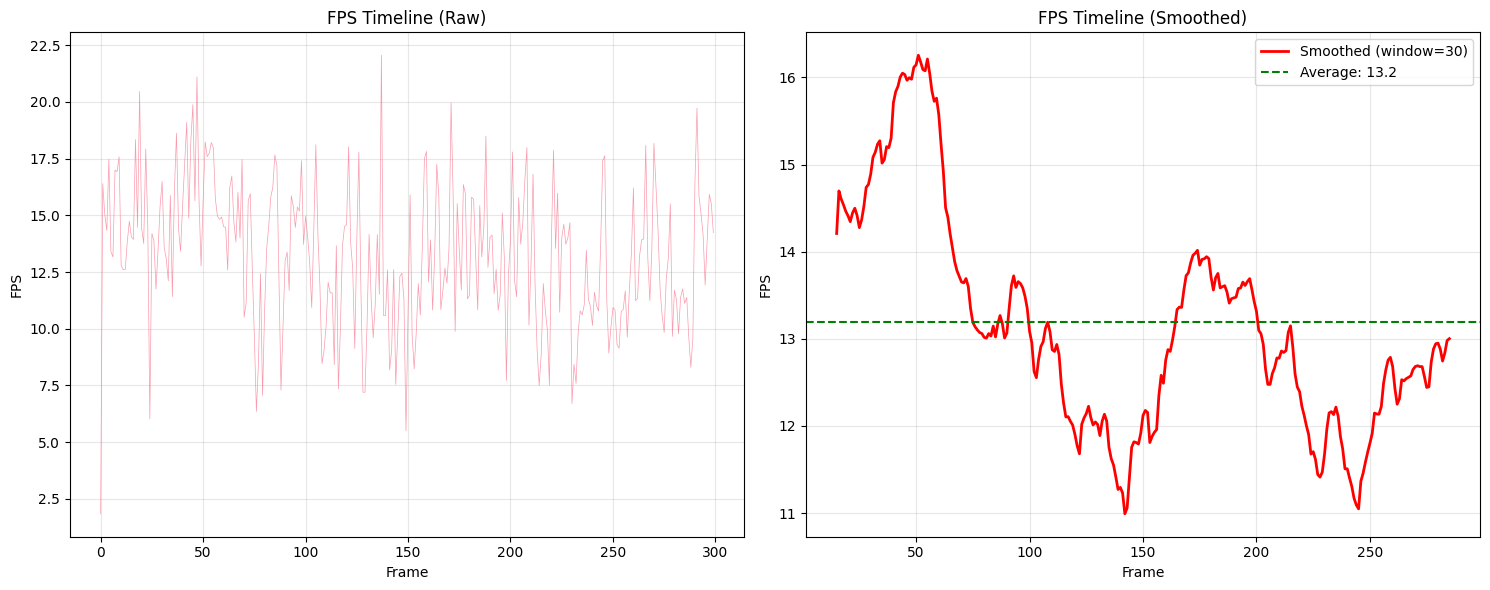


FPS STATISTICS:
Mean: 13.20
Median: 13.39
Std Dev: 3.10
Min: 1.84
Max: 22.06


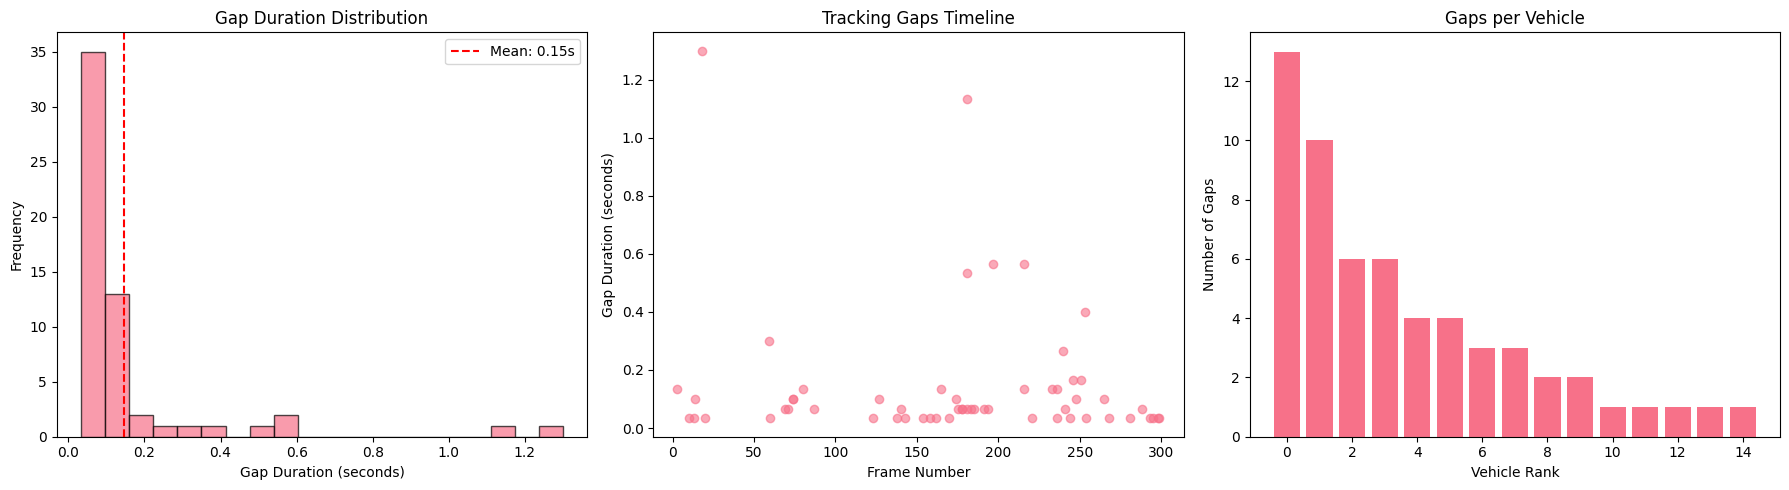


TRACKING STATISTICS:
Total gaps: 58
Unique vehicles with gaps: 15
Average gap duration: 0.15s
Max gap duration: 1.30s
Uncomment and modify the code above to analyze a specific experiment
Copy the experiment folder name from the list above


In [11]:
# LOAD AND ANALYZE EXPERIMENT
# Replace with your experiment folder name

# Example: Load latest experiment
experiment_folder = "yolov8n_video_1_cut_01-00_01-10_20251002_000229"
data = evaluator.load_experiment_results(experiment_folder)

if data:
    evaluator.analyze_single_experiment()
    visualizer.plot_fps_timeline()
    visualizer.plot_tracking_analysis()

print("Uncomment and modify the code above to analyze a specific experiment")
print("Copy the experiment folder name from the list above")

COMPARISON LOADED SUCCESSFULLY
Comparison ID: comparison_video_1_cut_01-00_01-10_20251002_000229
Video: video_1_cut_01-00_01-10
Models Tested: 5
Successful Tests: 5/5

MODEL COMPARISON ANALYSIS

COMPARISON OVERVIEW:
Video: video_1_cut_01-00_01-10
Models Tested: 5
Timestamp: 2025-10-02T00:10:19.875571
Successful Tests: 5/5

PERFORMANCE RANKING:
Rank Model      Overall  FPS      Detections  Parked  Gaps 
-----------------------------------------------------------------
1    yolov8n    81.9     13.2     1813        0       58   
2    yolov8s    75.0     6.4      2209        0       75   
3    yolov8m    72.9     3.6      2474        0       47   
4    yolov8l    71.9     2.5      2750        0       45   
5    yolov8x    71.0     1.8      2704        0       53   

STATISTICAL SUMMARY:
FPS - Mean: 5.5, Std: 4.6
Detections - Mean: 2390, Std: 388
Overall Score - Mean: 74.5, Std: 4.4

BEST PERFORMERS:
Overall: yolov8n (Score: 81.9)
Speed: yolov8n (FPS: 13.2)
Detections: yolov8l (Count: 2750)

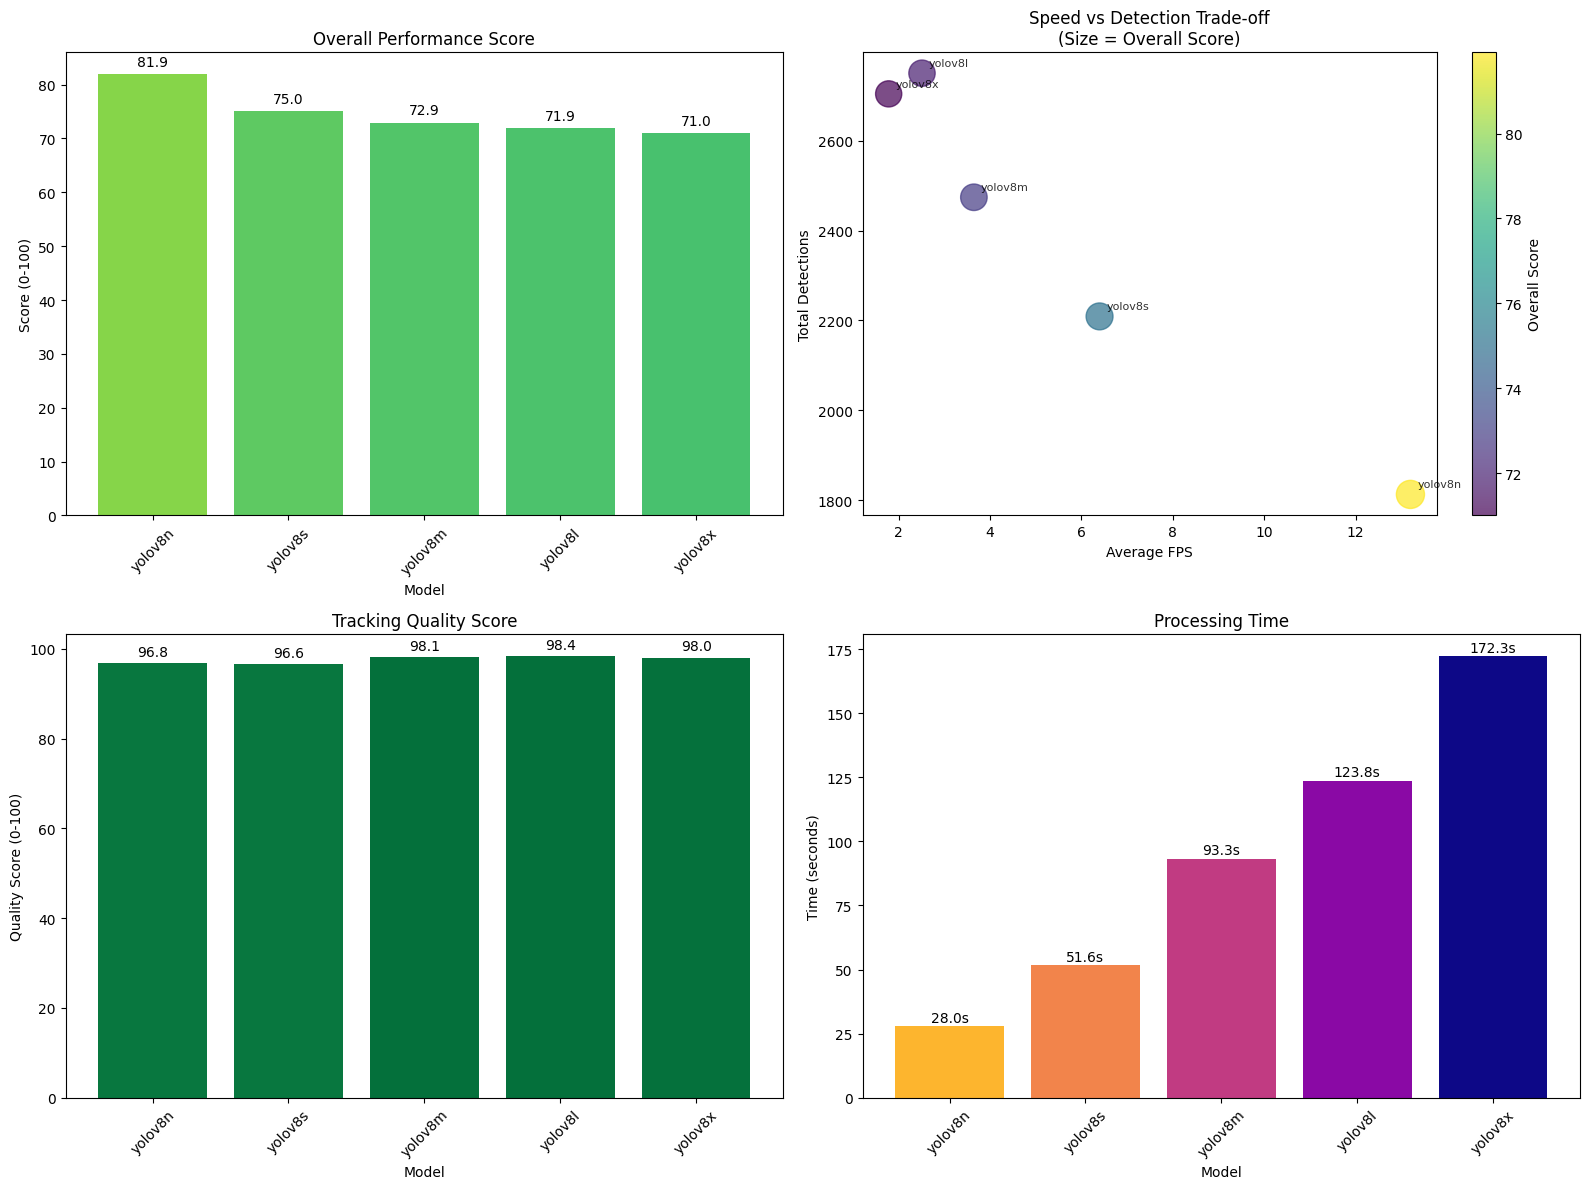

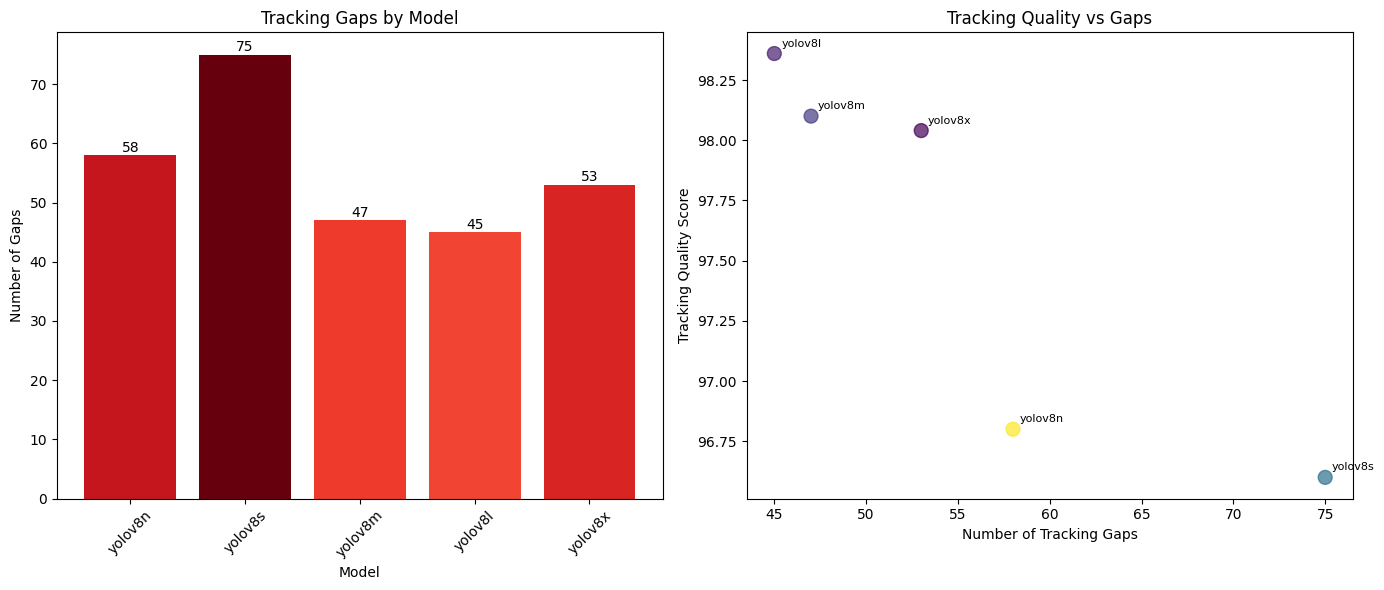

Uncomment and modify the code above to analyze a model comparison
Copy the comparison folder name from the list above


In [12]:
# LOAD AND ANALYZE MODEL COMPARISON
# Replace with your comparison folder name

# Example: Load latest comparison
comparison_folder = "comparison_video_1_cut_01-00_01-10_20251002_000229"
data = evaluator.load_comparison_results(comparison_folder)

if data:
    df = evaluator.analyze_model_comparison()
    visualizer.plot_model_comparison()
    visualizer.plot_tracking_analysis()

print("Uncomment and modify the code above to analyze a model comparison")
print("Copy the comparison folder name from the list above")

In [10]:
# CUSTOM ANALYSIS AND EXPORT

def export_analysis_report():
    """Export detailed analysis report"""
    if not evaluator.current_data:
        print("Load data first!")
        return
        
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    if evaluator.data_type == "experiment":
        # Single experiment report
        data = evaluator.current_data
        report = {
            'type': 'experiment',
            'timestamp': timestamp,
            'experiment_id': data['experiment_id'],
            'model': os.path.basename(data.get('model_path', '')),
            'video': os.path.basename(data.get('video_path', '')),
            'performance': data.get('performance', {}),
            'detection_stats': data.get('detection_stats', {}),
            'summary': {
                'fps_avg': data.get('performance', {}).get('avg_fps', 0),
                'detection_rate': data.get('detection_stats', {}).get('total_detections', 0) / 
                                max(1, data.get('detection_stats', {}).get('total_frames', 1)),
                'tracking_quality': 100 - (data.get('detection_stats', {}).get('tracking_gaps_total', 0) / 
                                          max(1, data.get('detection_stats', {}).get('total_detections', 1)) * 100)
            }
        }
        
        filename = f"analysis_report_experiment_{timestamp}.json"
        
    elif evaluator.data_type == "comparison":
        # Comparison report
        data = evaluator.current_data
        successful_results = [r for r in data['results'] if r.get('success', False)]
        df = pd.DataFrame(successful_results)
        
        report = {
            'type': 'comparison',
            'timestamp': timestamp,
            'comparison_id': data['comparison_id'],
            'video': data['video_name'],
            'models_tested': data['models_tested'],
            'successful_models': len(successful_results),
            'rankings': {
                'overall_best': df.loc[df['overall_score'].idxmax(), 'model_name'],
                'fastest': df.loc[df['avg_fps'].idxmax(), 'model_name'],
                'most_accurate': df.loc[df['total_detections'].idxmax(), 'model_name'],
                'best_tracking': df.loc[df['tracking_quality_score'].idxmax(), 'model_name']
            },
            'statistics': {
                'fps_mean': df['avg_fps'].mean(),
                'fps_std': df['avg_fps'].std(),
                'score_mean': df['overall_score'].mean(),
                'score_std': df['overall_score'].std()
            },
            'detailed_results': successful_results
        }
        
        filename = f"analysis_report_comparison_{timestamp}.json"
    
    # Save report
    os.makedirs("../output/analysis_reports", exist_ok=True)
    filepath = f"../output/analysis_reports/{filename}"
    
    with open(filepath, 'w') as f:
        json.dump(report, f, indent=2, default=str)
        
    print(f"Analysis report saved: {filepath}")
    return filepath

def compare_multiple_experiments():
    """Compare multiple individual experiments"""
    print("Enter experiment folder names (comma-separated):")
    print("Example: exp1,exp2,exp3")
    
    # This would be interactive in practice
    print("Function ready - modify to add specific experiment folders")

# Example usage (uncomment to use):
# report_path = export_analysis_report()
print("Analysis and export functions ready!")
print("- export_analysis_report() - Save detailed analysis")
print("- compare_multiple_experiments() - Compare multiple experiments")

Analysis and export functions ready!
- export_analysis_report() - Save detailed analysis
- compare_multiple_experiments() - Compare multiple experiments
